In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [55]:
fixed_band_indices = [3]
num_fixed_bands = len(fixed_band_indices)

# load stellar model grids
npzfile = np.load('./model_grids.npz')
stellarmodel_grid = npzfile['model_grid']
gridsize1, gridsize2, numtypes = stellarmodel_grid.shape[1:4]

# random linear grids for the GP prior. Will need to specify the logg and T grids! For the GP prior
dim1_grid = np.linspace(0, 1, stellarmodel_grid.shape[1])
dim2_grid = np.linspace(0, 1, stellarmodel_grid.shape[2])

# load data
npzfile = np.load('./WD_data.npz')
obsmags = npzfile['obsmags']
nobj, num_bands = obsmags.shape
obsmags_covar_chol = npzfile['obsmags_covar_chol']
obsmags_covar_logdet = npzfile['obsmags_covar_logdet']

In [90]:
nobj

13935

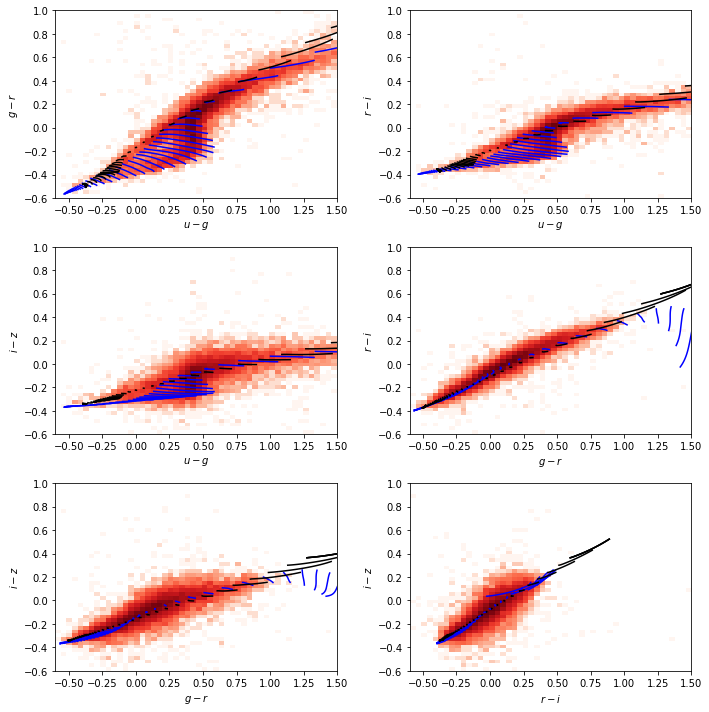

In [57]:
bandnames = ['u', 'g', 'r', 'i', 'z']
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.ravel()
off = -1
for i in range(num_bands-1):
    for j in range(i+1, num_bands-1):
        off += 1
        axs[off].set_xlabel('$'+bandnames[i]+'-'+bandnames[i+1]+'$')
        axs[off].set_ylabel('$'+bandnames[j]+'-'+bandnames[j+1]+'$')
        axs[off].hist2d(obsmags[:, i] - obsmags[:, i+1], obsmags[:, j] - obsmags[:, j+1], 
                        50, norm=LogNorm(), range=[[-0.6, 1.5], [-0.6, 1]], cmap='Reds')
        c = ['b', 'k']
        for t in range(stellarmodel_grid.shape[3]):
            for g in range(stellarmodel_grid.shape[2]):
                mod1 = stellarmodel_grid[i, :, g, t] - stellarmodel_grid[i+1, :, g, t]
                mod2 = stellarmodel_grid[j, :, g, t] - stellarmodel_grid[j+1, :, g, t]
                axs[off].plot(mod1.ravel(), mod2.ravel(), c=c[t])
                
fig.tight_layout()

In [58]:
max_correction_magnitude = 0.1
# max amplitude of the correction in magnitude space

In [92]:
# gridsize1: logg
# gridsize2: T

# Grid of stellar models
# Size: num_bands, gridsize1, gridsize2, numtypes
Stellarmodel_grid = tf.placeholder(shape=[num_bands, gridsize1, gridsize2, numtypes], dtype=tf.float32)

# "Lines" of corrections, in the two dimensions
# Defined on R
Corrections_dim1_unbounded = tf.Variable(np.random.randn(num_bands, gridsize1, numtypes)*0.01, dtype=tf.float32)
Corrections_dim2_unbounded = tf.Variable(np.random.randn(num_bands, gridsize2, numtypes)*0.01, dtype=tf.float32)

Dim1_grid = tf.placeholder(shape=[gridsize1, ], dtype=tf.float32)
Dim2_grid = tf.placeholder(shape=[gridsize1, ], dtype=tf.float32)

# We need to set the lengthscale/smoothness of the GP in the two dimensions.
# Those are positive (thus the exponentiation) and will be optimized.
GPlengthscale1 = tf.exp(tf.Variable(0.01, dtype=tf.float32, trainable=True))
GPlengthscale2 = tf.exp(tf.Variable(0.01, dtype=tf.float32, trainable=True))

# The (cholesky decompositions) of the covariance matrices
Diagnoise1 = tf.diag(tf.cast(tf.constant(np.repeat(1e-5, gridsize1)), dtype=tf.float32))
Diagnoise2 = tf.diag(tf.cast(tf.constant(np.repeat(1e-5, gridsize2)), dtype=tf.float32))
Covariance1 = tf.exp(-0.5*((Dim1_grid[:, None] - Dim1_grid[None, :])/GPlengthscale1)**2.0) + Diagnoise1
Covariance2 = tf.exp(-0.5*((Dim2_grid[:, None] - Dim2_grid[None, :])/GPlengthscale2)**2.0) + Diagnoise2
CovarianceChol1 = tf.cholesky(Covariance1)[None, None, :, :] * tf.ones((num_bands, numtypes, 1, 1))
CovarianceChol2 = tf.cholesky(Covariance2)[None, None, :, :] * tf.ones((num_bands, numtypes, 1, 1))
x1 = tf.transpose(Corrections_dim1_unbounded, [0, 2, 1])[:, :, :, None]
x2 = tf.transpose(Corrections_dim2_unbounded, [0, 2, 1])[:, :, :, None]
LogDet1 = tf.linalg.logdet(Covariance1) # scalar
LogDet2 = tf.linalg.logdet(Covariance2) # scalar
# Size: num_bands x numtypes
LogGPpriors1 = -0.5*tf.reduce_sum(x1 * tf.cholesky_solve(CovarianceChol1, x1), axis=(2, 3)) - 0.5*LogDet1
LogGPpriors2 = -0.5*tf.reduce_sum(x2 * tf.cholesky_solve(CovarianceChol2, x2), axis=(2, 3)) - 0.5*LogDet2
# scalars
LogGPprior1 = tf.reduce_sum(LogGPpriors1)
LogGPprior2 = tf.reduce_sum(LogGPpriors2)

# Set the corrections to zero in the bands that are fixed
Fixed_band_indices = tf.placeholder(shape=[num_fixed_bands, ], dtype=tf.int32)
tf.scatter_update(Corrections_dim1_unbounded, Fixed_band_indices, tf.zeros((num_fixed_bands, gridsize1, numtypes)))
tf.scatter_update(Corrections_dim2_unbounded, Fixed_band_indices, tf.zeros((num_fixed_bands, gridsize1, numtypes)))

# Now we map them to a limited space: [-max_correction_magnitude, +max_correction_magnitude]
# (tf.sigmoid maps R on [0, 1])
Corrections_dim1 = max_correction_magnitude * (2*tf.sigmoid(Corrections_dim1_unbounded) - 1)
Corrections_dim2 = max_correction_magnitude * (2*tf.sigmoid(Corrections_dim2_unbounded) - 1)

# Add the line corrections to form a grid
# Correction(logg, T) = Correction(T) + Correction(logg)
# so the grid is in [-2*max_correction_magnitude, 2*max_correction_magnitude]
# Size: num_bands x gridsize1 x gridsize2 x numtypes
Corrections_grid = Corrections_dim1[:, :, None, :] + Corrections_dim2[:, None, :, :] 

# Apply them to the stellar models and rotate axes
# Size: gridsize1, gridsize2, numtypes, num_bands
Corrected_stellarmodel_grid_c = Stellarmodel_grid + Corrections_grid
Corrected_stellarmodel_grid = tf.transpose(Corrected_stellarmodel_grid_c, perm=[1, 2, 3, 0])

# Now define the observations
# Size: nobj x num_bands
Obsmags = tf.placeholder(shape=[None, num_bands], dtype=tf.float32)
Obsmags_covar_chol = tf.placeholder(shape=[None, num_bands, num_bands], dtype=tf.float32)
Obsmags_covar_logdet = tf.placeholder(shape=[None, ], dtype=tf.float32)

# Compute the log likelihoods per object and per model element
# Size: nobj, gridsize1, gridsize2, numtypes, num_bands, 1
Delta = Obsmags[:, None, None, None, :, None] - Corrected_stellarmodel_grid[None, :, :, :, :, None]
Cov = Obsmags_covar_chol[:, None, None, None, :, :] * tf.ones((1, gridsize1, gridsize2, numtypes, 1, 1))

if True:# GAUSSIAN CHI2
    # Size: nobj, gridsize1, gridsize2, numtypes
    Chi2s = tf.reduce_sum(tf.multiply(Delta, tf.cholesky_solve(Cov, Delta)), axis=(4, 5))
    # Size: nobj x gridsize1, gridsize2, numtypes
    Loglikes = - 0.5 * (Chi2s + Obsmags_covar_logdet[:, None, None, None])
else: # STUDENT T
    Nu = tf.Variable(1.0, dtype=tf.float32)
    # Size: nobj, gridsize1, gridsize2, numtypes
    Nud2 = (Nu + num_bands)/2
    Chi2s = tf.reduce_sum(tf.multiply(Delta, tf.cholesky_solve(Cov, Delta)), axis=(4, 5))
    Loglikes = tf.lgamma(Nud2) - tf.lgamma(Nu/2) - num_bands/2 * tf.log(Nu) \
        - 0.5 * Obsmags_covar_logdet[:, None, None, None] - Nud2 *tf.log(1 + Chi2s / Nu)
    # Size: nobj x gridsize1, gridsize2, numtypes

# Finally, compute the log evidence per object and the final log posterior
# Size: nobj
Logevidences = tf.reduce_logsumexp(Loglikes, axis=(1, 2, 3))
# Size: scalar!
MinusLogprob = - tf.reduce_sum(Logevidences, axis=0) - LogGPprior1 - LogGPprior2

In [93]:
num_iterations = 200
learning_rate = 2e-2

Optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)\
    .minimize(MinusLogprob)
    
with tf.Session() as sess:

    # initialize variables
    sess.run(tf.global_variables_initializer())
    
    # loop: iterations of the optimizer
    for i in range(num_iterations):
        
        subset = np.random.choice(nobj, nobj // 100, replace=False)
        
        _, minuslogprob, corrections_dim1, corrections_dim2 =\
           sess.run([Optimizer, MinusLogprob, Corrections_dim1, Corrections_dim2],
                     feed_dict={
                         Fixed_band_indices: fixed_band_indices,
                         Stellarmodel_grid: stellarmodel_grid,
                         Obsmags: obsmags[subset, :],
                         Obsmags_covar_chol: obsmags_covar_chol[subset, :, :],
                         Obsmags_covar_logdet: obsmags_covar_logdet[subset],
                         Dim1_grid: dim1_grid, Dim2_grid: dim2_grid
                     }) 
        
        if i % 100 == 0:
            print('Iteration', i, ': minus log posterior = ', minuslogprob)
            print(sess.run([GPlengthscale1, GPlengthscale2]))
            
        corrected_stellarmodel_grid, = sess.run([Corrected_stellarmodel_grid_c],
                     feed_dict={
                         Fixed_band_indices: fixed_band_indices,
                         Stellarmodel_grid: stellarmodel_grid,
                         Obsmags: obsmags[subset, :],
                         Obsmags_covar_chol: obsmags_covar_chol[subset, :, :],
                         Obsmags_covar_logdet: obsmags_covar_logdet[subset],
                         Dim1_grid: dim1_grid, Dim2_grid: dim2_grid
                     })


Iteration 0 : minus log posterior =  -1765.8662
[1.0304545, 1.0304545]
Iteration 100 : minus log posterior =  -7015.3457
[1.4577196, 1.0214331]


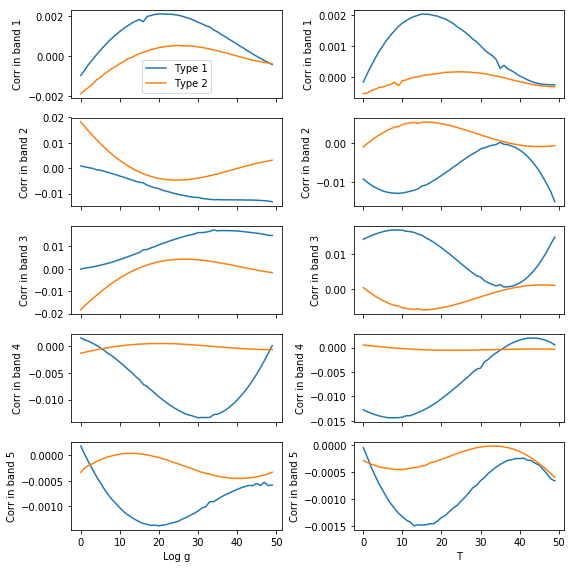

In [94]:
# num_bands, gridsize1, numtypes
fig, axs = plt.subplots(num_bands, 2, figsize=(8, 8), sharex=True)
for i in range(num_bands):
    axs[i, 0].plot(range(len(dim1_grid)), corrections_dim1[i, :, 0], label='Type 1')
    axs[i, 0].plot(range(len(dim1_grid)), corrections_dim1[i, :, 1], label='Type 2')
    axs[i, 1].plot(range(len(dim2_grid)), corrections_dim2[i, :, :])
    axs[i, 0].set_ylabel('Corr in band '+str(i+1))
    axs[i, 1].set_ylabel('Corr in band '+str(i+1))
axs[-1, 0].set_xlabel('Log g')
axs[-1, 1].set_xlabel('T')
axs[0, 0].legend()
fig.tight_layout()


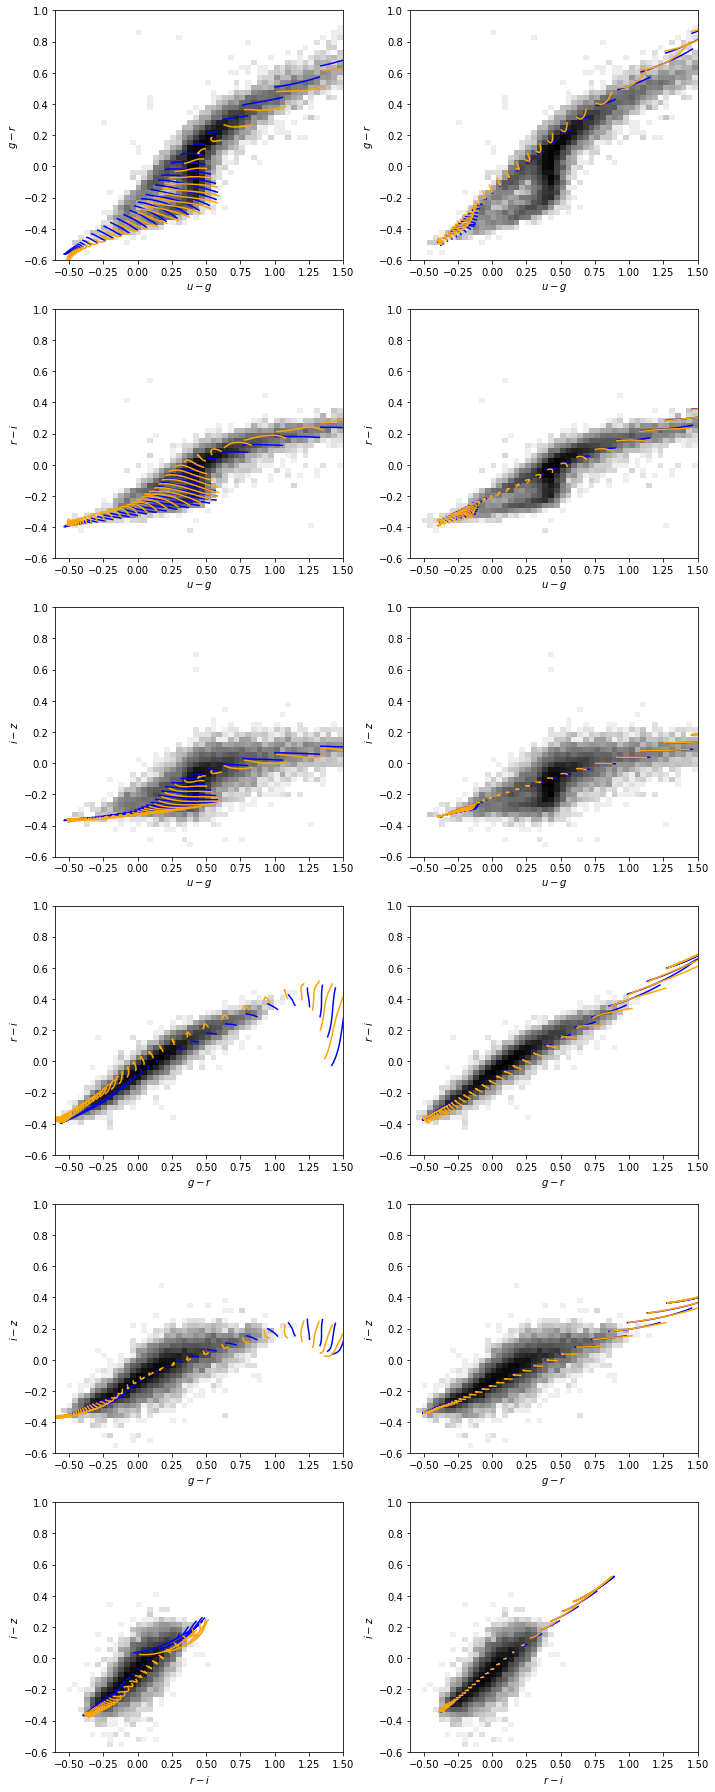

In [100]:
fig, axs = plt.subplots(6, 2, figsize=(10, 25))
#axs = axs.ravel()
off = -1
for i in range(num_bands-1):
    for j in range(i+1, num_bands-1):
        off += 1
        norm = LogNorm()#None;#
        for t in range(stellarmodel_grid.shape[3]):
            axs[off, t].hist2d(obsmags[:, i] - obsmags[:, i+1], obsmags[:, j] - obsmags[:, j+1], 
                            50, norm=norm, range=[[-0.6, 1.5], [-0.6, 1]], cmap='Greys', zorder=0)
            axs[off, t].set_xlabel('$'+bandnames[i]+'-'+bandnames[i+1]+'$')
            axs[off, t].set_ylabel('$'+bandnames[j]+'-'+bandnames[j+1]+'$')
            for g in range(stellarmodel_grid.shape[2]):
                mod1 = stellarmodel_grid[i, :, g, t] - stellarmodel_grid[i+1, :, g, t]
                mod2 = stellarmodel_grid[j, :, g, t] - stellarmodel_grid[j+1, :, g, t]
                axs[off, t].plot(mod1.ravel(), mod2.ravel(), c='blue', zorder=1)
                mod1 = corrected_stellarmodel_grid[i, :, g, t] - corrected_stellarmodel_grid[i+1, :, g, t]
                mod2 = corrected_stellarmodel_grid[j, :, g, t] - corrected_stellarmodel_grid[j+1, :, g, t]
                axs[off, t].plot(mod1.ravel(), mod2.ravel(), c='orange', zorder=2)
                
fig.tight_layout()